# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [203]:
#导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
#读取训练数据
train_data = pd.read_csv('data/train.csv')

In [205]:
#这里先开始根据业务逻辑看哪些数据是不需要被加入训练的，防止引入噪声
#然后看看哪些数据需要填入缺失值
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
#首先PassengerId, Name, Ticket理论上和生存率没关系，需要被去除
#Cabin虽然具备相关性，但是缺失数据太多，远大于50%，因此也需要被去除
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

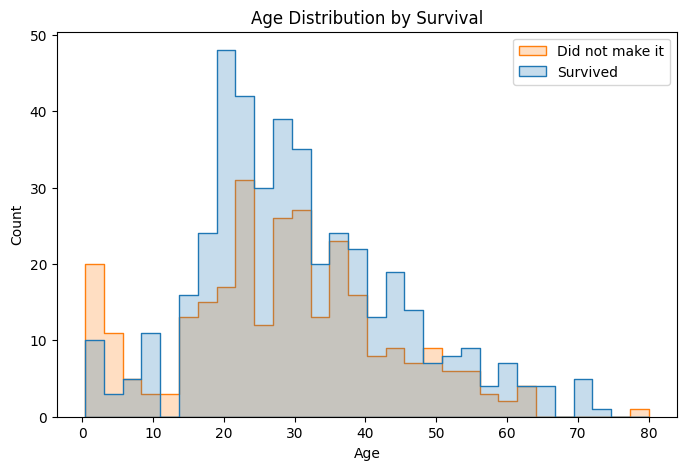

In [207]:
#Age数据有些缺失，但理论上和生存率有很大关系，这里验证一下
plt.figure(figsize=(8,5))
sns.histplot(data=train_data, x='Age', hue='Survived', bins=30, kde=False, element='step')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(['Did not make it', 'Survived'])
plt.show()


In [208]:
#然后Sex和Embarked需要转为数字来帮助训练，这里我直接用map来实现
#Embarked只缺两个数，直接使用众数填进去
from sklearn.impute import SimpleImputer
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0})
imputer = SimpleImputer(strategy='most_frequent')
train_data['Embarked'] = train_data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})


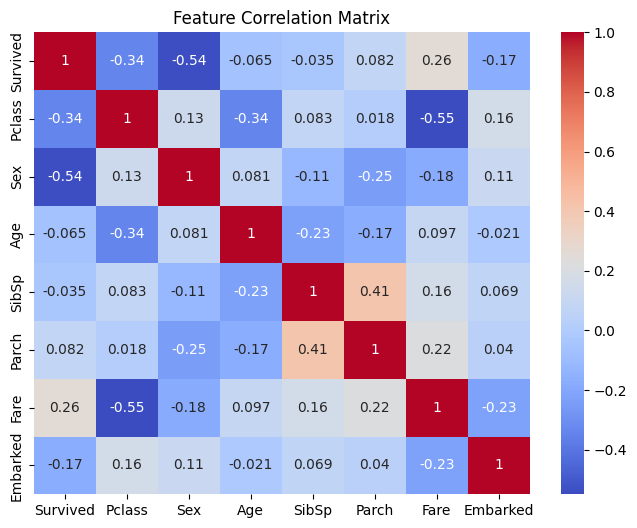

In [209]:
#先生成一张热力图，看看其他数据和survived的相关性，下面会用到
plt.figure(figsize=(8,6))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
#虽然我手头有test测试集可以使用，但我选择先拿已有结果的train的一部分来做学习
#我把训练数据按照8:2进行分割，80%用于训练，20%用于测试
#分割标准参考上面热力图中最重要的三个参数，survived，Pclass，Sex，他们被分割的比例要尽量接近
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(train_data, train_data[["Survived","Pclass","Sex"]]):
    split_train_set = train_data.iloc[train_indices]
    split_test_set = train_data.iloc[test_indices]

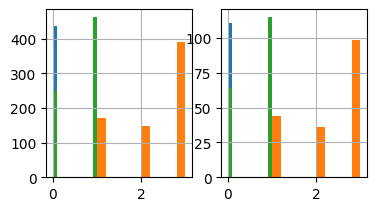

In [211]:
#检查一下分布是否合理
plt.subplot(2,3,1)
split_train_set['Survived'].hist()
split_train_set['Pclass'].hist()
split_train_set['Sex'].hist()
plt.subplot(2,3,2)
split_test_set['Survived'].hist()
split_test_set['Pclass'].hist()
split_test_set['Sex'].hist()
plt.show()

In [ ]:
#上图可以看出分割出来的两个集的survived，Pclass，Sex分布是很接近的，好耶！
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
#使用一个GirdSearchCV来找到该训练集下随机森林的最优参数
X_train = split_train_set.drop('Survived', axis=1)
Y_train = split_train_set['Survived']
clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,                # 5折交叉验证
    scoring='accuracy', 
    return_train_score=True
)
grid_search.fit(X_train, Y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,300


In [ ]:
#使用最优参数的随机森林来对测试集进行预测
final_clf = grid_search.best_estimator_
X_test = split_test_set.drop('Survived', axis=1)
Y_test = split_test_set['Survived']
final_clf.score(X_test, Y_test)

0.8324022346368715

In [ ]:
#看起来准确度不错！现在来预测test数据集，然后把完成的预测写进submission提交给kaggle，任务完成！
test_data = pd.read_csv('data/test.csv')
test_data.info()
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0})
test_data['Embarked'] = test_data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())
test_data = test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
final_predictions = final_clf.predict(test_data)
test_data_with_id = pd.read_csv('data/test.csv')
submission = pd.DataFrame({
    'PassengerId': test_data_with_id['PassengerId'],
    'Survived': final_predictions
})
submission.to_csv('data/submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
